/usr/local/lib/python3.7/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


R2= 0.798841001958353
R2= 0.8006735227441383
R2 máximo encontrado:  0.8006735227441383
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 86
    # data points      = 672
    # variables        = 4
    chi-square         = 33.3374844
    reduced chi-square = 0.04990641
    Akaike info crit   = -2010.40302
    Bayesian info crit = -1992.36198
[[Variables]]
    k0:     -0.24990898 +/- 0.05102859 (20.42%) (init = -0.2208361)
    k1:     -14.6910115 +/- 4.27717377 (29.11%) (init = -8.542877)
    k2:      0 (fixed)
    k3:      0 (fixed)
    beta_n:  0.49999989 +/- 1.9238e-04 (0.04%) (init = 0.5)
    beta_a:  0.25163938 +/- 0.00978504 (3.89%) (init = 0.2117544)
    delta:   1 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k0, k1)         = 0.995
    C(k1, beta_a)     = 0.763
    C(k0, beta_a)     = 0.732
    C(k0, beta_n)     = -0.475
    C(k1, beta_n)     = -0.474
    C(beta_n, beta_a) = -0.432


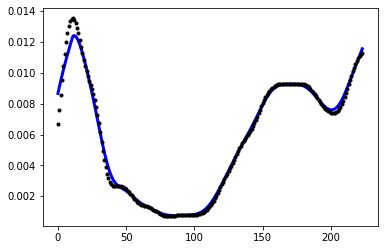

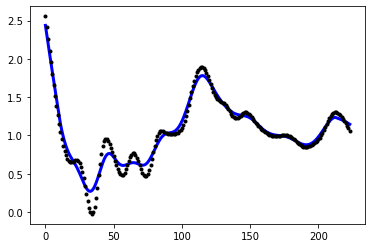

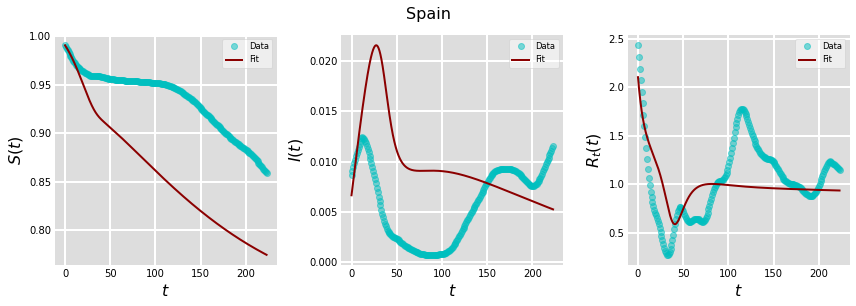

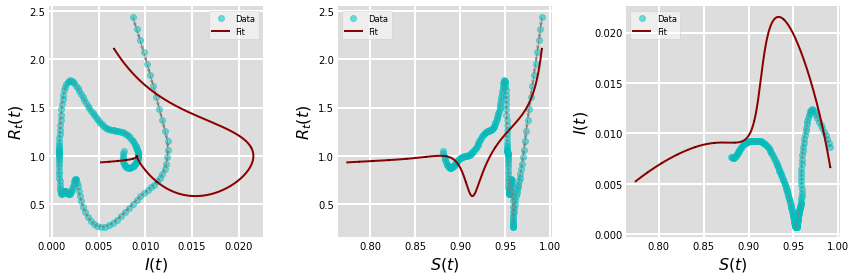

In [ ]:
!pip install -q sdeint
import sdeint
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
!pip install -q lmfit
import lmfit
from lmfit import Parameters, Minimizer, report_fit
!pip install -q numdifftools
import numdifftools
import pickle
from zipfile import ZipFile
!pip install -q tsmoothie
from tsmoothie.smoother import LowessSmoother

#####################################
#   Modelo SIR Polleti Gamma fixo   #
#####################################

name = 'Spain'
name1 = 'Spain'

#Sn_data = pd.read_table('Spain_Sn.dat', header=None)
#Sa_data = pd.read_table('Spain_Sa.dat', header=None)
#I_data = pd.read_table('Spain_I7.dat', header=None)
#R_data = pd.read_table('Spain_R.dat', header=None)

#S_data = Sn_data[1]+Sa_data[1]

S_data = pd.read_table(name+'_S.csv', header=None)
I_data = pd.read_table(name+'_I10.csv', header=None)
R_data = pd.read_table(name+'_R.csv', header=None)

N = 230
#N = len(S_data)-1

S_data = S_data[0][0:N]
I_data = I_data[0][0:N]
R_data = R_data[0][0:N]

#beta_n = 0.35
#beta_a = 0.05
gamma = 0.1

Rt_data = []
Rt_data.append(1+(I_data[1]-I_data[0])/(gamma*I_data[0]))
for i in range(0,len(I_data)-1):
  Rt_data.append(1+(I_data[i+1]-I_data[i])/(gamma*I_data[i]))
Rt_data = pd.DataFrame(Rt_data).rolling(7,center=True, min_periods=7).mean().dropna()[0].to_numpy(dtype='float')

S_data = S_data[3:N-3]
I_data = I_data[3:N-3]
R_data = R_data[3:N-3]

t0 = np.array(range(len(S_data)))
t = np.linspace(0, int(1*len(S_data))-1, 100*N)

# The SIRD model differential equations.
def deriv(y, t, beta_n, beta_a, gamma, k0, k1, k2, k3, delta):
    S, I, Rt = y
    dSdt = -gamma*Rt*I
    dIdt = gamma*(Rt-1)*I
    dRtdt = -(beta_n + (beta_n*beta_a))*I*Rt - beta_n*(beta_n*beta_a)*S*I/gamma + delta*(k0 -k1*I -k2*Rt + k3*S)*(gamma*Rt - (beta_n*beta_a)*S)*(-gamma*Rt + beta_n*S)/(gamma*(beta_n-(beta_n*beta_a)))
    return dSdt, dIdt, dRtdt

# Initial conditions vector
y0 = S_data[3], I_data[3], Rt_data[3]

# Data to be fited
data2 = []
data2.append(S_data)
data2.append(I_data)
data2.append(Rt_data)
data2 = np.array(data2)

# Objective function to be minimized
def func(params,t,data):
    k0 = params['k0']
    k1 = params['k1']
    k2 = params['k2']
    k3 = params['k3']
    beta_n = params['beta_n']
    beta_a = params['beta_a']
    delta = params['delta']
    ret = odeint(deriv, y0, t, args=(beta_n, beta_a, gamma, k0, k1, k2, k3, delta))
    S1, I1, Rt1 = ret.T
    resid = []
    pre_resid = []
    pre_resid.append(S1)
    pre_resid.append(I1)
    pre_resid.append(Rt1)
    pre_resid = np.array(pre_resid)
    resid.append(pre_resid-data)
    resid = np.array(resid)
    return  resid

R2 = 0.1
R = []
while R2<0.967:
  try:
    params = Parameters()
    params.add('k0', value=.1)
    params.add('k1', value=.1)
    params.add('k2', value=0, vary=False)
    params.add('k3', value=0, vary=False)
    params.add('beta_n', value=0.5*np.random.rand(), min=0, max=0.5, vary=True)
    params.add('beta_a', value=0.1, min=0.05, max=1, vary=True)
    params.add('delta', value=1, min=0, vary=False)

    minner = Minimizer(func, params, fcn_args=(t0,data2))

    # Fit using Nelder-Mead

    out1 = minner.minimize(method= 'least_squares')


    #lmfit.report_fit(out1)

    print('R2=',1 - out1.residual.var() / np.var(data2))

    # Fit using the Levenberg-Marquardt method with the result of the previous fit as initial guess
    out2 = minner.minimize(method='leastsq', params=out1.params)

    #lmfit.report_fit(out2)

    print('R2=',1 - out2.residual.var() / np.var(data2))
    R2 = 1 - out2.residual.var() / np.var(data2)
  except:
    continue
  R.append(R2)
  print('R2 máximo encontrado: ',max(R))
  R2 = 1

#with open(str(name)+'_fit.pkl', 'wb') as f:
     #pickle.dump(out2, f)

with open(str(name)+'_fit.pkl', 'rb') as f1:
     out3 = pickle.load(f1)

lmfit.report_fit(out3)

params = out3.params
k0 = params['k0']
k1 = params['k1']
k2 = params['k2']
k3 = params['k3']
beta_n = params['beta_n']
beta_a = params['beta_a']
delta = params['delta']

ret = odeint(deriv, y0, t, args=(beta_n, beta_a, gamma, k0, k1, k2, k3, delta))
S, I, Rt = ret.T

smoother = LowessSmoother(smooth_fraction=0.1, iterations=1)
smoother.smooth(I_data)

# plot the smoothed timeseries with intervals
plt.figure()
plt.plot(smoother.smooth_data[0], linewidth=3, color='blue')
plt.plot(smoother.data[0], '.k')
plt.show()

I_data = smoother.smooth_data[0]

smoother = LowessSmoother(smooth_fraction=0.1, iterations=1)
smoother.smooth(Rt_data)

# plot the smoothed timeseries with intervals
plt.figure()
plt.plot(smoother.smooth_data[0], linewidth=3, color='blue')
plt.plot(smoother.data[0], '.k')
plt.show()

Rt_data = smoother.smooth_data[0]

fig = plt.figure(facecolor='w',figsize=(12,4))
ax = fig.add_subplot(131, facecolor='#dddddd', axisbelow=True)
ax.plot(t0, S_data, 'co', alpha=0.5, label='Data')
ax.plot(t, S, 'k', alpha=1, lw=2, label='Fit', color='darkred')
ax.set_xlabel(r'$\it{t}$', fontsize=16)
ax.set_ylabel(r'$\it{S(t)}$', fontsize=16)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend(fontsize='small')
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
ax1 = fig.add_subplot(132, facecolor='#dddddd', axisbelow=True)
ax1.plot(t0, I_data, 'co', alpha=0.5, label='Data')
ax1.plot(t, I, 'k', alpha=1, lw=2, label='Fit', color='darkred')
ax1.set_xlabel(r'$\it{t}$', fontsize=16)
ax1.set_ylabel(r'$\it{I(t)}$', fontsize=16)
ax1.yaxis.set_tick_params(length=0)
ax1.xaxis.set_tick_params(length=0)
ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax1.legend(fontsize='small')
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax1.spines[spine].set_visible(False)
ax2 = fig.add_subplot(133, facecolor='#dddddd', axisbelow=True)
ax2.plot(t0, Rt_data, 'co', alpha=0.5, label='Data')
ax2.plot(t, Rt, 'k', alpha=1, lw=2, label='Fit', color='darkred')
ax2.set_xlabel(r'$\it{t}$', fontsize=16)
ax2.set_ylabel(r'$\it{R_t(t)}$', fontsize=16)
ax2.yaxis.set_tick_params(length=0)
ax2.xaxis.set_tick_params(length=0)
ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax2.legend(fontsize='small')
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax2.spines[spine].set_visible(False)
suptitle = plt.suptitle(name1, fontsize=16, y=1.05)
plt.tight_layout()
plt.savefig('upper_panel_'+name+'.png', format='png', dpi=600, bbox_extra_artists=(suptitle,), bbox_inches="tight")
ax.set_rasterized(True)
ax1.set_rasterized(True)
ax2.set_rasterized(True)
plt.savefig('upper_panel_'+name+'.eps', format='eps', bbox_extra_artists=(suptitle,), bbox_inches="tight")
plt.show()

N2 = 1

N3 = 20

U = np.asarray(I_data[1:-N3])-np.asarray(I_data[:-1-N3])
V = np.asarray(Rt_data[1:-N3])-np.asarray(Rt_data[:-1-N3])
W = np.asarray(S_data[1:-N3])-np.asarray(S_data[:-1-N3])


N1 = 5

arrows = int(len(I)/N1)

N_arrows = 9

U1 = np.asarray(I[1+N1::N1])-np.asarray(I[:-1-N1:N1])
V1 = np.asarray(Rt[1+N1::N1])-np.asarray(Rt[:-1-N1:N1])
W1 = np.asarray(S[1+N1::N1])-np.asarray(S[:-1-N1:N1])

#U1 = .05*U1 / np.sqrt(U1**2 + V1**2)
#V1 = .05*V1 / np.sqrt(U1**2 + V1**2)

fig = plt.figure(facecolor='w',figsize=(12,4))
ax = fig.add_subplot(131, facecolor='#dddddd', axisbelow=True)
ax.plot(I_data[:-N3], Rt_data[:-N3], 'co', alpha=0.5, lw=2, label='Data')
ax.plot(I, Rt, 'k-', alpha=1, lw=2, label='Fit', zorder=9, color='darkred')
ax.quiver(I_data[:-1-N3], Rt_data[:-1-N3], U, V, angles='xy', scale_units='xy', scale=1, headwidth=4, headlength=8, headaxislength=6, color='gray', zorder=8)
ax.quiver(I[:-1-N1:int(arrows/N_arrows)*N1], Rt[:-1-N1:int(arrows/N_arrows)*N1], U1[::int(arrows/N_arrows)], V1[::int(arrows/N_arrows)], angles='xy', scale_units='xy', scale=1, headwidth=4, headlength=8, headaxislength=6, zorder=10)
#ax.quiver(I[int(arrows/N_arrows)*N1:-1-N1:int(arrows/N_arrows)*N1], Rt[int(arrows/N_arrows)*N1:-1-N1:int(arrows/N_arrows)*N1], U1[int(arrows/N_arrows)::int(arrows/N_arrows)], V1[int(arrows/N_arrows)::int(arrows/N_arrows)], angles='xy', scale_units='xy', scale=1, headwidth=4, headlength=8, headaxislength=6, zorder=10)
ax.set_xlabel(r'$\it{I(t)}$', fontsize=16)
ax.set_ylabel(r'$\it{R_t(t)}$', fontsize=16)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend(fontsize='small')
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
ax1 = fig.add_subplot(132, facecolor='#dddddd', axisbelow=True)
ax1.plot(S_data[:-N3], Rt_data[:-N3], 'co', alpha=0.5, lw=2, label='Data')
ax1.plot(S, Rt, 'k-', alpha=1, lw=2, label='Fit', zorder=9, color='darkred')
ax1.quiver(S_data[:-1-N3], Rt_data[:-1-N3], W, V, angles='xy', scale_units='xy', scale=1, headwidth=4, headlength=8, headaxislength=6, color='gray', zorder=8)
ax1.quiver(S[:-1-N1:int(arrows/N_arrows)*N1], Rt[:-1-N1:int(arrows/N_arrows)*N1], W1[::int(arrows/N_arrows)], V1[::int(arrows/N_arrows)], angles='xy', scale_units='xy', scale=1, headwidth=4, headlength=8, headaxislength=6, zorder=10)
ax1.set_xlabel(r'$\it{S(t)}$', fontsize=16)
ax1.set_ylabel(r'$\it{R_t(t)}$', fontsize=16)
ax1.yaxis.set_tick_params(length=0)
ax1.xaxis.set_tick_params(length=0)
ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax1.legend(fontsize='small')
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax1.spines[spine].set_visible(False)
ax2 = fig.add_subplot(133, facecolor='#dddddd', axisbelow=True)
ax2.plot(S_data[:-N3], I_data[:-N3], 'co', alpha=0.5, lw=2, label='Data')
ax2.plot(S, I, 'k-', alpha=1, lw=2, label='Fit', zorder=9, color='darkred')
ax2.quiver(S_data[:-1-N3], I_data[:-1-N3], W, U, angles='xy', scale_units='xy', scale=1, headwidth=4, headlength=8, headaxislength=6, color='gray', zorder=8)
ax2.quiver(S[:-1-N1:int(arrows/N_arrows)*N1], I[:-1-N1:int(arrows/N_arrows)*N1], W1[::int(arrows/N_arrows)], U1[::int(arrows/N_arrows)], angles='xy', scale_units='xy', scale=1, headwidth=4, headlength=8, headaxislength=6, zorder=10)
ax2.set_xlabel(r'$\it{S(t)}$', fontsize=16)
ax2.set_ylabel(r'$\it{I(t)}$', fontsize=16)
ax2.yaxis.set_tick_params(length=0)
ax2.xaxis.set_tick_params(length=0)
ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax2.legend(fontsize='small')
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax2.spines[spine].set_visible(False)
plt.tight_layout()
plt.savefig('Risk_Diagrams_'+name+'.png', format='png', dpi=600)
ax.set_rasterized(True)
ax1.set_rasterized(True)
ax2.set_rasterized(True)
plt.savefig('Risk_Diagrams_'+name+'.eps', format='eps')
plt.show()

zipObj = ZipFile(name+'_fit.zip', 'w')
zipObj.write(name+'_fit.pkl')
zipObj.write('upper_panel_'+name+'.png')
zipObj.write('upper_panel_'+name+'.eps')
zipObj.write('Risk_Diagrams_'+name+'.png')
zipObj.write('Risk_Diagrams_'+name+'.eps')
zipObj.write(name+'_S.csv')
zipObj.write(name+'_I10.csv')
zipObj.write(name+'_R.csv')
zipObj.close()